In [33]:
# Zhen - Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [34]:
# Zhen - Load TTC subway delay data
ttc_delays_path = 'delays_combined.csv'
delay_codes_path = 'ttc-subway-delay-codes.csv'

In [35]:
ttc_delays = pd.read_csv(ttc_delays_path)
delay_codes = pd.read_csv(delay_codes_path)

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `[TTC Subway Map](ttc-subway-map.png)'


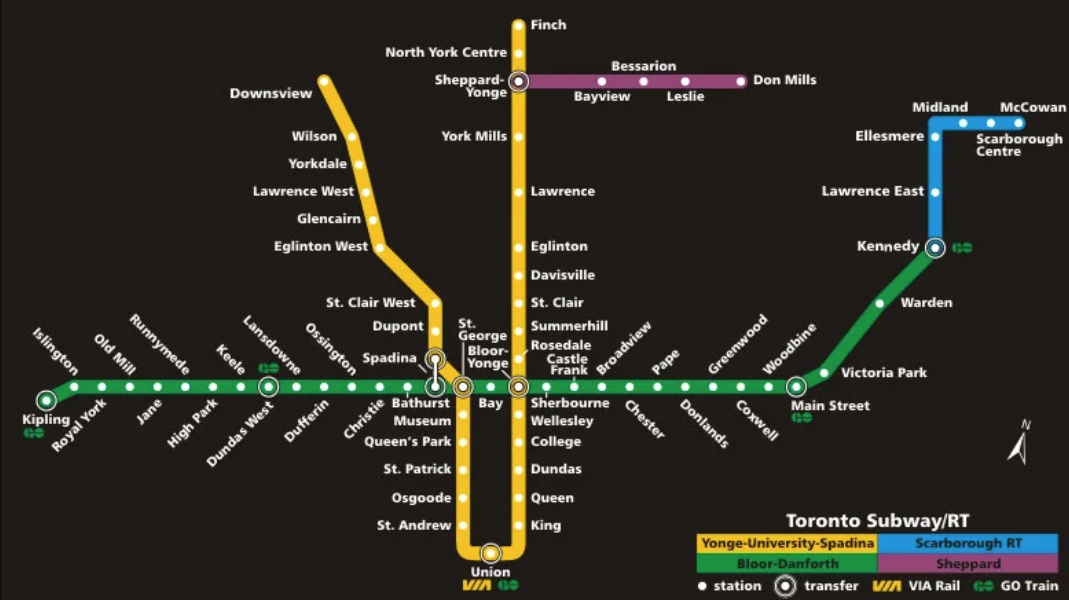

In [36]:
#Zhen - Display TTC subway map
![TTC Subway Map](ttc-subway-map.png)
from IPython.display import Image, display

display(Image(filename='ttc-subway-map.png'))

In [37]:
#Data cleaning: rename and merge station names
station_renaming = {
    "KENNEDY BD STATION": "KENNEDY STATION",
    "BLOOR STATION": "YONGE-BLOOR STATION",
    "YONGE UNIVERSITY LINE": "YONGE-BLOOR STATION",
    "YONGE BD STATION": "YONGE-BLOOR STATION",
    "ST GEORGE YUS STATION": "ST GEORGE STATION"
}

# Apply renaming to the 'station' column
ttc_delays['Station'] = ttc_delays['Station'].replace(station_renaming)

# Save the updated data to a new CSV file
output_path = 'updated_ttc_delays.csv'
ttc_delays.to_csv(output_path, index=False)

print(f"Updated data saved to {output_path}")

Updated data saved to updated_ttc_delays.csv


In [38]:
# Zhen - Clean column names in the delay_codes dataset
delay_codes.columns = delay_codes.columns.str.strip()  # Remove leading/trailing whitespace
delay_codes.columns = delay_codes.columns.str.upper()  # Standardize to uppercase for consistency

# Clean and rename relevant columns in delay codes
delay_codes_cleaned = delay_codes[['SUB RMENU CODE', 'CODE DESCRIPTION']].rename(
    columns={'SUB RMENU CODE': 'CODE', 'CODE DESCRIPTION': 'DESCRIPTION'}
).drop_duplicates()

# Check for missing or duplicate values in the TTC delays dataset
print("Missing values in TTC delays dataset:")
print(ttc_delays.isnull().sum())

# Remove duplicate rows from TTC delays dataset
ttc_delays_cleaned = ttc_delays.drop_duplicates()

# Preview cleaned datasets
print(delay_codes_cleaned.head())  # Preview cleaned delay codes
print(ttc_delays_cleaned.head())  # Preview cleaned TTC delays


Missing values in TTC delays dataset:
Date                0
Time                0
Day                 0
Station             0
Code                1
Min Delay           0
Min Gap             0
Bound           56466
Line              684
Vehicle             0
Unnamed: 10    217879
Unnamed: 11    217879
Unnamed: 12    217879
dtype: int64
    CODE          DESCRIPTION
0   EUAC     Air Conditioning
1   EUAL  Alternating Current
2  EUATC   ATC RC&S Equipment
3   EUBK               Brakes
4   EUBO                 Body
         Date  Time        Day                Station   Code  Min Delay  \
0  2014-01-01  0:21  Wednesday  VICTORIA PARK STATION  MUPR1         55   
1  2014-01-01  2:06  Wednesday      HIGH PARK STATION   SUDP          3   
2  2014-01-01  2:40  Wednesday       SHEPPARD STATION  MUNCA          0   
3  2014-01-01  3:10  Wednesday      LANSDOWNE STATION   SUDP          3   
4  2014-01-01  3:20  Wednesday    YONGE-BLOOR STATION  MUSAN          5   

   Min Gap Bound Line  Vehicle  

In [39]:
ttc_merged = ttc_delays.merge(
    delay_codes_cleaned, how='left', left_on='Code', right_on='CODE'
).drop(columns=['CODE'])

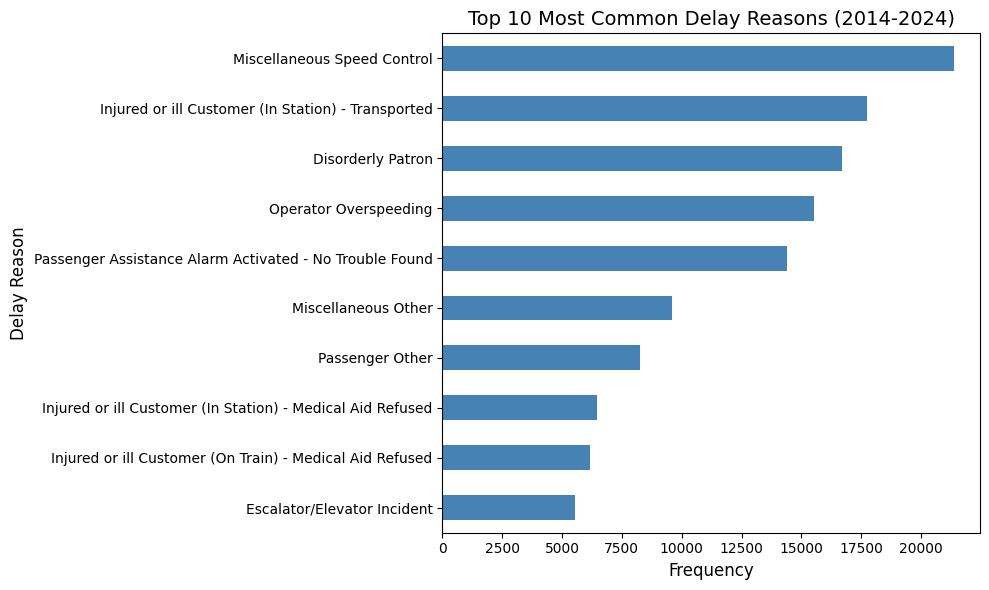

In [40]:
# Zhen - Count and visualize the most common delay reasons
top_delay_reasons = (
    ttc_merged['DESCRIPTION']
    .value_counts()
    .head(10)
    .sort_values(ascending=True)  # Sort for better visualization
)

# Plot the top 10 delay reasons
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
top_delay_reasons.plot(kind='barh', color='steelblue')
plt.title('Top 10 Most Common Delay Reasons (2014-2024)', fontsize=14)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Delay Reason', fontsize=12)
plt.tight_layout()
plt.show()

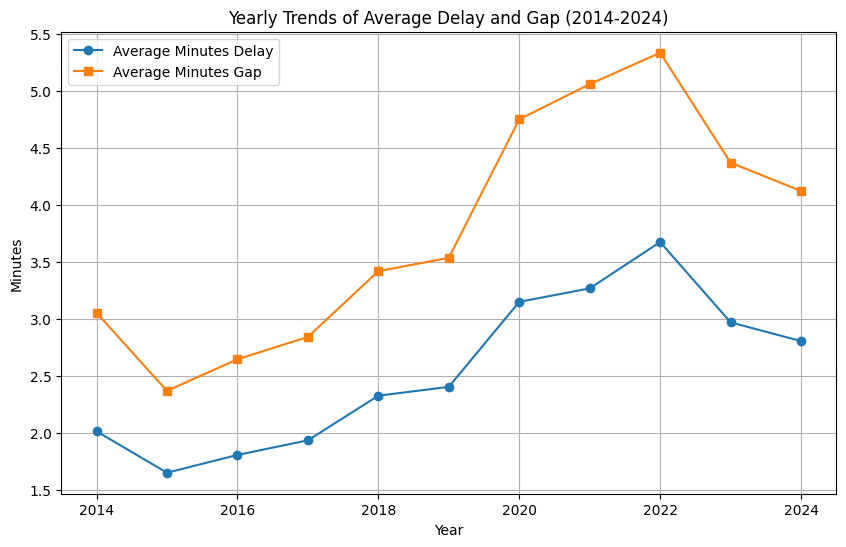

In [41]:
# Extract year from the 'Date' column
ttc_delays_merged = ttc_delays.merge(
    delay_codes_cleaned, how='left', left_on='Code', right_on='CODE'
).drop(columns=['CODE'])
ttc_delays_merged['Year'] = pd.to_datetime(ttc_delays_merged['Date'], errors='coerce').dt.year

# Group by year for average delays and gaps
yearly_delays = ttc_delays_merged.groupby('Year')[['Min Delay', 'Min Gap']].mean().reset_index()

# Group by line and direction for average delay analysis
line_direction_delays = ttc_delays_merged.groupby(['Line', 'Bound'])[['Min Delay']].mean().reset_index()

# Identify the most affected stations
station_delays = ttc_delays_merged.groupby('Station')[['Min Delay']].sum().sort_values(by='Min Delay', ascending=False).reset_index()

# 1. Yearly delay trends
plt.figure(figsize=(10, 6))
plt.plot(yearly_delays['Year'], yearly_delays['Min Delay'], marker='o', label='Average Minutes Delay')
plt.plot(yearly_delays['Year'], yearly_delays['Min Gap'], marker='s', label='Average Minutes Gap')
plt.title('Yearly Trends of Average Delay and Gap (2014-2024)')
plt.xlabel('Year')
plt.ylabel('Minutes')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
# Zhen - Extract hour from the 'Time' column for time-of-day analysis
ttc_merged['Hour'] = pd.to_datetime(ttc_merged['Time'], errors='coerce').dt.hour

<ipython-input-42-0d5e4fa0b19f>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ttc_merged['Hour'] = pd.to_datetime(ttc_merged['Time'], errors='coerce').dt.hour


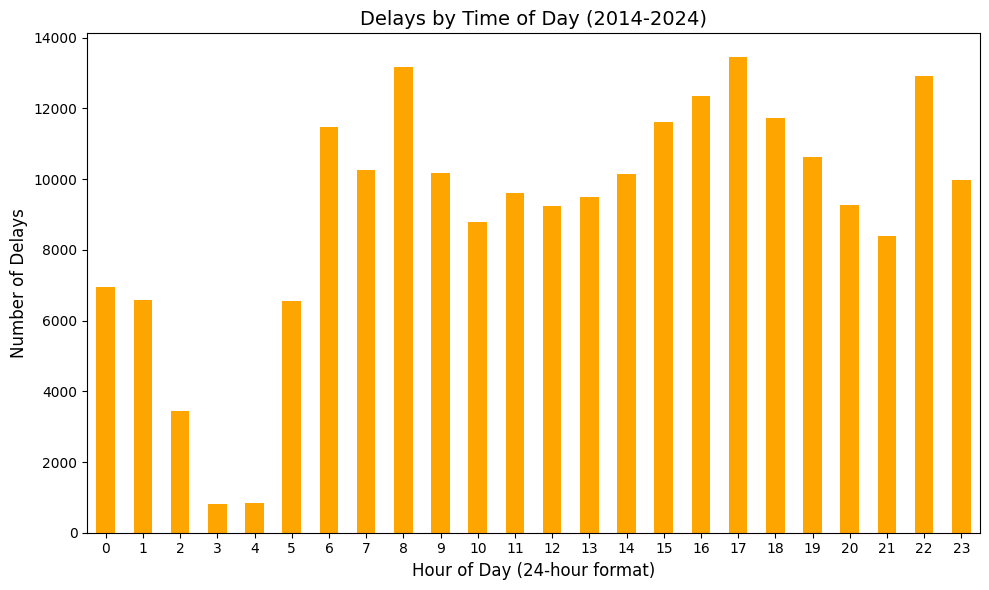

In [43]:
# Zhen - Bar Chart: Delays by Time of Day
time_of_day_delays = ttc_merged.groupby('Hour').size()
plt.figure(figsize=(10, 6))
time_of_day_delays.plot(kind='bar', color='orange')
plt.title('Delays by Time of Day (2014-2024)', fontsize=14)
plt.xlabel('Hour of Day (24-hour format)', fontsize=12)
plt.ylabel('Number of Delays', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

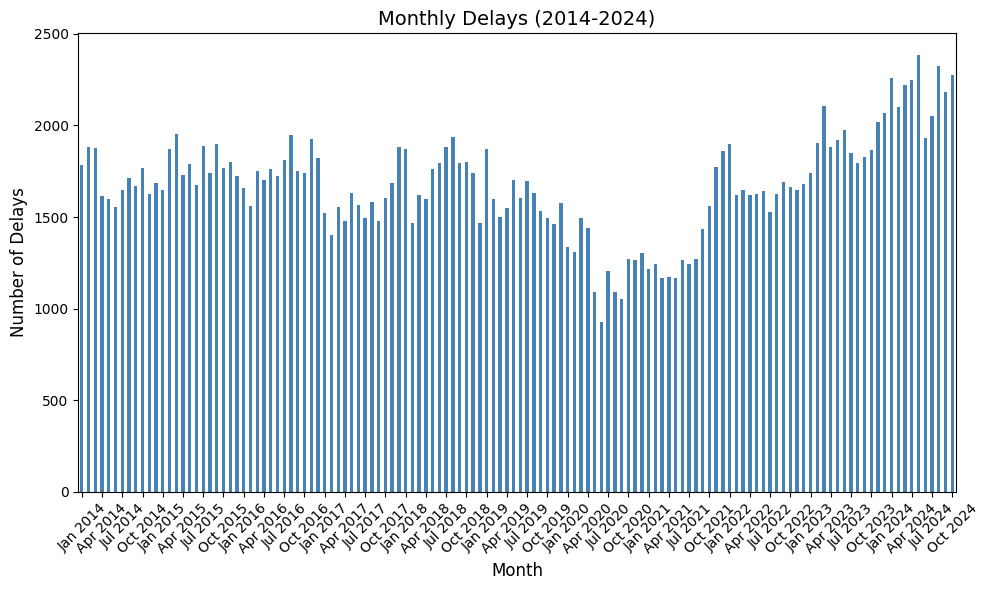

In [44]:
# Zhen - Bar Chart delays by month
ttc_merged['Date'] = pd.to_datetime(ttc_merged['Date'], errors='coerce')
monthly_delays = ttc_merged.groupby(ttc_merged['Date'].dt.to_period('M')).size()

# Plot monthly delays with cleaner x-axis
plt.figure(figsize=(10, 6))
monthly_delays.plot(kind='bar', color='steelblue')
plt.title('Monthly Delays (2014-2024)', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Delays', fontsize=12)

# Adjust x-axis ticks to show fewer labels for clarity
plt.xticks(
    ticks=range(0, len(monthly_delays), 3),  # Show every 3rd month
    labels=[monthly_delays.index[i].strftime('%b %Y') for i in range(0, len(monthly_delays), 3)],
    rotation=45,
    fontsize=10
)

plt.tight_layout()
plt.show()


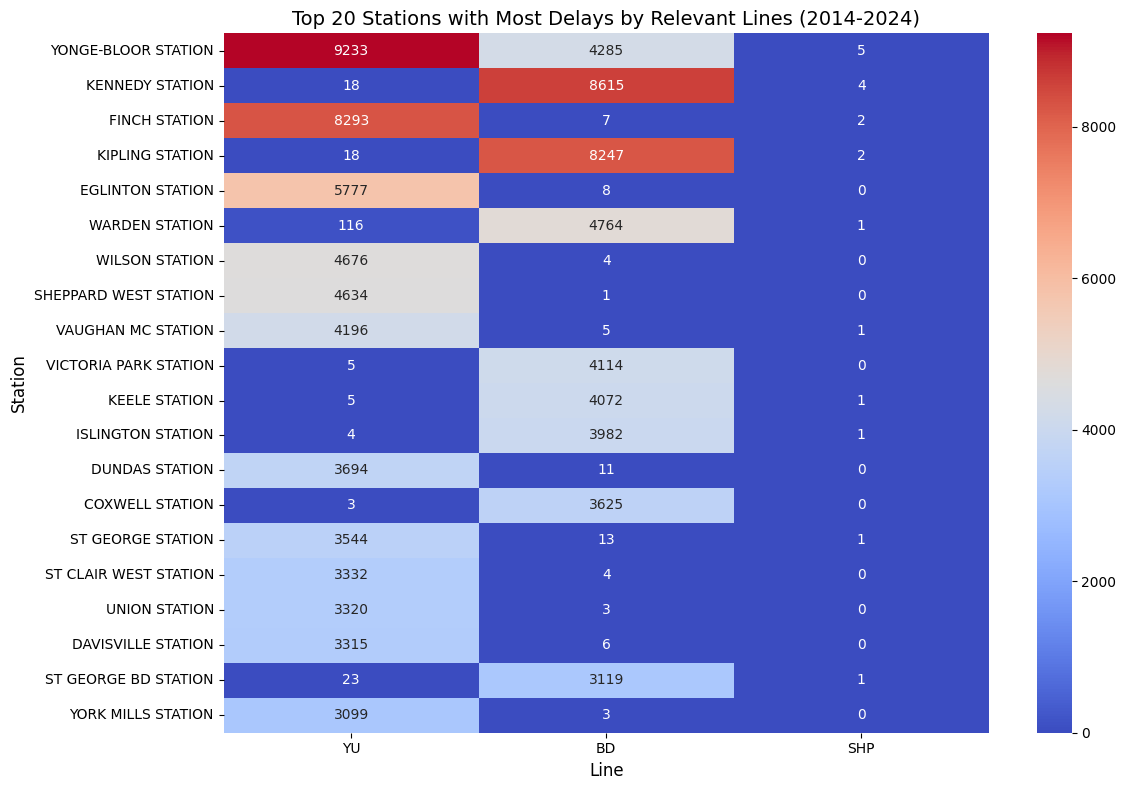

In [49]:
# Zhen - Heatmap: Top 20 Stations with Most Delays by Line
station_line_delays = ttc_merged.groupby(['Station', 'Line']).size().unstack(fill_value=0)

# Sort stations by total delays
station_line_delays_sorted = station_line_delays.loc[
    station_line_delays.sum(axis=1).sort_values(ascending=False).index
]

# Filter the data to include only the relevant lines
filtered_lines = ['YU', 'BD', 'SHP']
filtered_station_line_delays = station_line_delays_sorted[filtered_lines]

# Limit to top 20 stations for readability
filtered_top_stations = filtered_station_line_delays.head(20)

# Plot the refined heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(filtered_top_stations, cmap="coolwarm", annot=True, fmt="d", cbar=True)
plt.title('Top 20 Stations with Most Delays by Relevant Lines (2014-2024)', fontsize=14)
plt.xlabel('Line', fontsize=12)
plt.ylabel('Station', fontsize=12)
plt.tight_layout()
plt.show()




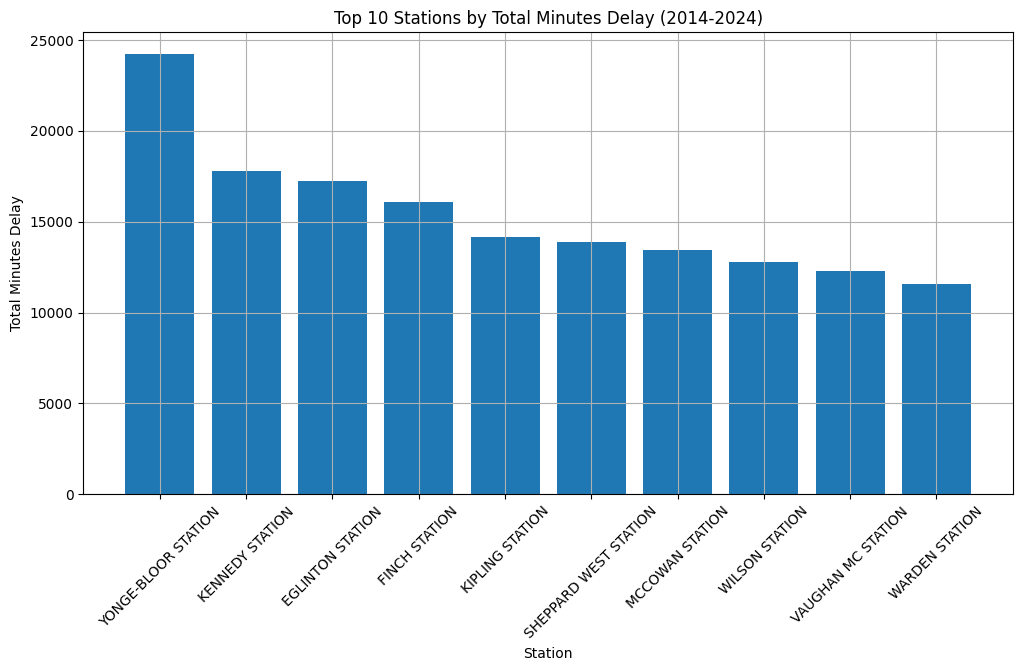

In [46]:
# 3. Most affected stations
plt.figure(figsize=(12, 6))
top_stations = station_delays.head(10)
plt.bar(top_stations['Station'], top_stations['Min Delay'])
plt.title('Top 10 Stations by Total Minutes Delay (2014-2024)')
plt.xlabel('Station')
plt.ylabel('Total Minutes Delay')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

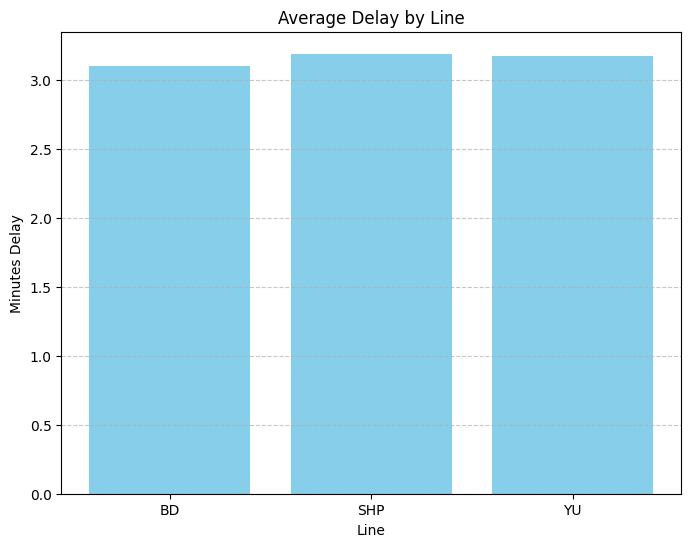

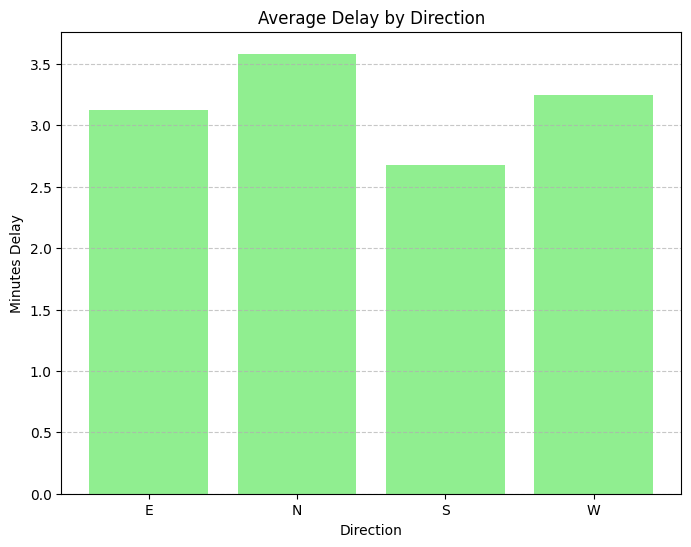

In [50]:
 # Filter line_direction_delays to include only the specified lines and bounds
valid_lines = ['YU', 'BD', 'SHP']
valid_bounds = ['N', 'S', 'W', 'E']
filtered_line_direction_delays = line_direction_delays[
    (line_direction_delays['Line'].isin(valid_lines)) &
    (line_direction_delays['Bound'].isin(valid_bounds))
]

# Plot 1: Average Delay by Line
plt.figure(figsize=(8, 6))
line_avg_delays = filtered_line_direction_delays.groupby('Line')['Min Delay'].mean().reset_index()
plt.bar(line_avg_delays['Line'], line_avg_delays['Min Delay'], color='skyblue')
plt.title('Average Delay by Line')
plt.xlabel('Line')
plt.ylabel('Minutes Delay')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot 2: Average Delay by Direction
plt.figure(figsize=(8, 6))
direction_avg_delays = filtered_line_direction_delays.groupby('Bound')['Min Delay'].mean().reset_index()
plt.bar(direction_avg_delays['Bound'], direction_avg_delays['Min Delay'], color='lightgreen')
plt.title('Average Delay by Direction')
plt.xlabel('Direction')
plt.ylabel('Minutes Delay')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

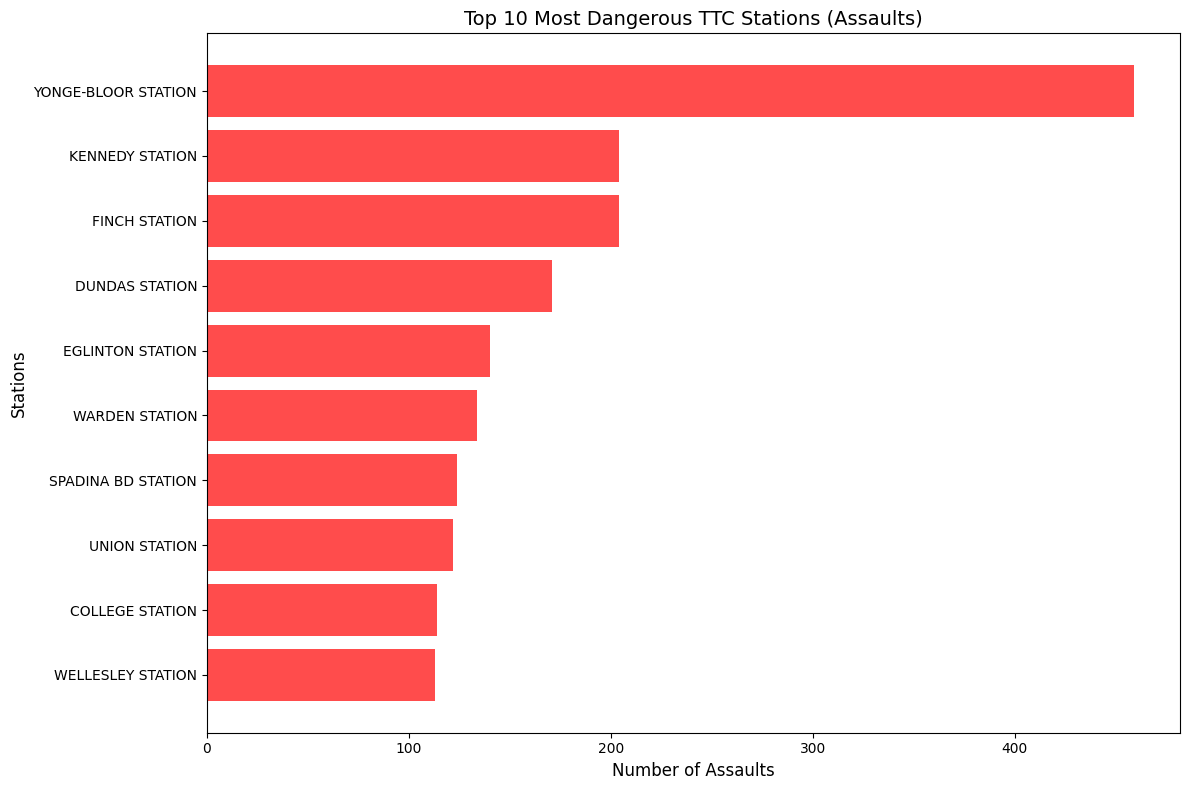

In [52]:
# Define keywords related to assault or violence
assault_keywords = ["assault", "violent", "attack"]

# Filter delay codes for assault-related incidents based on descriptions
assault_codes = delay_codes[
    delay_codes["CODE DESCRIPTION"].str.contains("|".join(assault_keywords), case=False, na=False)
]

# Extract relevant columns for reference
assault_code_list = assault_codes[["SUB RMENU CODE", "CODE DESCRIPTION"]]

# Filter delays data for rows matching the assault-related codes
assault_data = ttc_delays[ttc_delays["Code"].isin(assault_code_list["SUB RMENU CODE"])]

# Group by station and count the number of assault-related incidents
assault_station_counts = assault_data.groupby("Station").size().reset_index(name="Assault Count")

# Sort stations by the number of incidents, descending
assault_station_counts_sorted = assault_station_counts.sort_values(by="Assault Count", ascending=False)

# Plot the top 10 most dangerous stations for assaults
plt.figure(figsize=(12, 8))
plt.barh(assault_station_counts_sorted.head(10)["Station"],
         assault_station_counts_sorted.head(10)["Assault Count"],
         color="red", alpha=0.7)
plt.xlabel("Number of Assaults", fontsize=12)
plt.ylabel("Stations", fontsize=12)
plt.title("Top 10 Most Dangerous TTC Stations (Assaults)", fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis for readability
plt.tight_layout()
plt.show()
